# Part 1: Image Text CLIP Embeddings

## Intro demo

Dataset: https://www.kaggle.com/datasets/vikashrajluhaniwal/fashion-images

In [1]:
from transformers import CLIPProcessor, CLIPModel
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/home/tnsonlahh/Downloads/zazencodes-season-1-main/clip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
!ls ~/.cache/huggingface/hub | grep p-vit-base-p

models--openai--clip-vit-base-patch32


In [5]:
# Function to get text embedding
def get_text_embedding(text: str):
    inputs = clip_processor(text=[text], return_tensors="pt", padding=True)
    text_embeddings = clip_model.get_text_features(**inputs)
    return text_embeddings

In [7]:
import requests
from PIL import Image

In [8]:
# Function to get image embedding
def get_image_embedding(image_url: str):
    image = Image.open(requests.get(image_url, stream=True, headers={"User-Agent": "AlexCrawler/1.0 (alexgalea.ca; agalea91@gmail.com)"}).raw)
    inputs = clip_processor(images=image, return_tensors="pt")
    image_embeddings = clip_model.get_image_features(**inputs)
    return image_embeddings

In [9]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/62/Anne-Louis_Girodet_de_Roussy-Trioson_-_Coriolanus_Taking_Leave_of_his_Family_-_2019.169.1_-_National_Gallery_of_Art.jpg"

image_embedding = get_image_embedding(image_url)

In [11]:
from IPython.display import Image as DisplayImage

In [12]:
DisplayImage(url=image_url)

In [13]:
text = "man in red toga saying bye to his family"
text_embedding = get_text_embedding(text)

In [14]:
import torch

In [15]:
torch.nn.CosineSimilarity()(text_embedding, image_embedding)

tensor([0.3179], grad_fn=<SumBackward1>)

In [16]:
text = "birthday party for my grandma"
text_embedding = get_text_embedding(text)
torch.nn.CosineSimilarity()(text_embedding, image_embedding)

tensor([0.1594], grad_fn=<SumBackward1>)

In [17]:

text = "airplane landing on a remote island"
text_embedding = get_text_embedding(text)
torch.nn.CosineSimilarity()(text_embedding, image_embedding)

tensor([0.1066], grad_fn=<SumBackward1>)

## Ecom demo



In [20]:
from pathlib import Path

In [21]:
images = []
images.extend(Path("/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/Footwear/Men/Images/images_with_product_ids").glob("*.jpg"))
images.extend(Path("/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/Footwear/Women/Images/images_with_product_ids").glob("*.jpg"))

In [22]:
len(images)

1580

In [23]:
import numpy as np
from itertools import islice

def batched(iterable, n):
    it = iter(iterable)
    while True:
        batch = list(islice(it, n))
        if not batch:
            return
        yield batch


In [24]:
from torchvision.utils import make_grid
from torchvision.io import read_image 
from torchvision import transforms

In [25]:
def get_text_embedding(text):
    # Load the CLIP model
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    inputs = clip_processor(text=[text], return_tensors="pt", padding=True)
    text_embeddings = clip_model.get_text_features(**inputs)
    return text_embeddings[0]

def load_transform_images(image_paths):
    target_size = (240, 240)
    reshape_transform = lambda image_tensor: transforms.Resize(target_size)(image_tensor).expand(3, -1, -1)
    images = [reshape_transform(read_image(image)) for image in image_paths]
    return images

def get_image_embeddings(image_paths):
    # Load the CLIP model
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    images = load_transform_images(image_paths)
    inputs = clip_processor(images=images, return_tensors="pt")
    image_embeddings = clip_model.get_image_features(**inputs)
    return image_embeddings

In [28]:
batch_size = 500
total_batches = int(np.ceil(len(images)/batch_size))

i = 0
embedding_files = []
for image_fps in batched(images, batch_size):
    i += 1
    print(f"Processing batch {i}/{total_batches}")
    file_name = f"/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/embeddings/batch_{i}.pt"
    torch.save(get_image_embeddings(image_fps), file_name)
    embedding_files.append(file_name)

Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4


In [29]:
embedding_files

['/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/embeddings/batch_1.pt',
 '/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/embeddings/batch_2.pt',
 '/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/embeddings/batch_3.pt',
 '/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/embeddings/batch_4.pt']

In [30]:
image_embeddings = torch.cat([torch.load(fp) for fp in embedding_files])

In [34]:
from tqdm import tqdm

In [35]:
def rank_items(text_embedding: torch.Tensor, image_embeddings: torch.Tensor):
    scores = []
    cosine_similarity = torch.nn.CosineSimilarity()
    for image_embedding in tqdm(image_embeddings):
        score = cosine_similarity(text_embedding.unsqueeze(dim=0), image_embedding.unsqueeze(dim=0))
        scores.append(float(score))
    return scores

In [36]:
scores = rank_items(get_text_embedding("red"), image_embeddings)

  0%|          | 0/1580 [00:00<?, ?it/s]/tmp/ipykernel_8731/3996139147.py:6: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  scores.append(float(score))
100%|██████████| 1580/1580 [00:00<00:00, 45628.24it/s]


In [37]:
scores

[0.16353873908519745,
 0.1528802216053009,
 0.16428355872631073,
 0.16537651419639587,
 0.17856596410274506,
 0.21693933010101318,
 0.2176063060760498,
 0.21199095249176025,
 0.22210529446601868,
 0.15520235896110535,
 0.15785527229309082,
 0.13904885947704315,
 0.17203651368618011,
 0.19623400270938873,
 0.20926806330680847,
 0.1535467952489853,
 0.1555374413728714,
 0.14634118974208832,
 0.15580300986766815,
 0.13788282871246338,
 0.1620718538761139,
 0.1436956226825714,
 0.19575029611587524,
 0.17984436452388763,
 0.16181035339832306,
 0.16046005487442017,
 0.17343410849571228,
 0.15985193848609924,
 0.16350671648979187,
 0.17614266276359558,
 0.17788287997245789,
 0.18835949897766113,
 0.1513255536556244,
 0.16985191404819489,
 0.18001240491867065,
 0.14546026289463043,
 0.16307879984378815,
 0.23093439638614655,
 0.16145896911621094,
 0.17005638778209686,
 0.14752042293548584,
 0.14942841231822968,
 0.15493500232696533,
 0.19562193751335144,
 0.16136763989925385,
 0.17375729978084

In [38]:
np.argsort(scores)

array([  84,  548, 1093, ...,  494, 1240,  831], shape=(1580,))

In [39]:
idx = np.argsort(scores)
np.array(scores)[idx][::-1]

array([0.25029138, 0.24806099, 0.24227697, ..., 0.12555379, 0.12133291,
       0.11839043], shape=(1580,))

In [40]:
idx = np.argsort(scores)
np.array(images)[idx][::-1]

array([PosixPath('/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/Footwear/Women/Images/images_with_product_ids/44722.jpg'),
       PosixPath('/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/Footwear/Women/Images/images_with_product_ids/4743.jpg'),
       PosixPath('/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/Footwear/Men/Images/images_with_product_ids/41867.jpg'),
       ...,
       PosixPath('/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/Footwear/Women/Images/images_with_product_ids/59056.jpg'),
       PosixPath('/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/Footwear/Men/Images/images_with_product_ids/11983.jpg'),
       PosixPath('/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/Footwear/Men/Images/images_with_product_ids/26554.jpg')],
      shape=(1580,), dtype=object)

In [41]:
i = 0
for image in np.array(images)[idx][::-1]:
    i += 1
    print(image)
    if i >= 5:
        break

/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/Footwear/Women/Images/images_with_product_ids/44722.jpg
/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/Footwear/Women/Images/images_with_product_ids/4743.jpg
/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/Footwear/Men/Images/images_with_product_ids/41867.jpg
/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/Footwear/Women/Images/images_with_product_ids/15499.jpg
/home/tnsonlahh/Downloads/zazencodes-season-1-main/data/Footwear/Women/Images/images_with_product_ids/14340.jpg


In [42]:
from IPython.display import display
from IPython.display import Image as DisplayImage



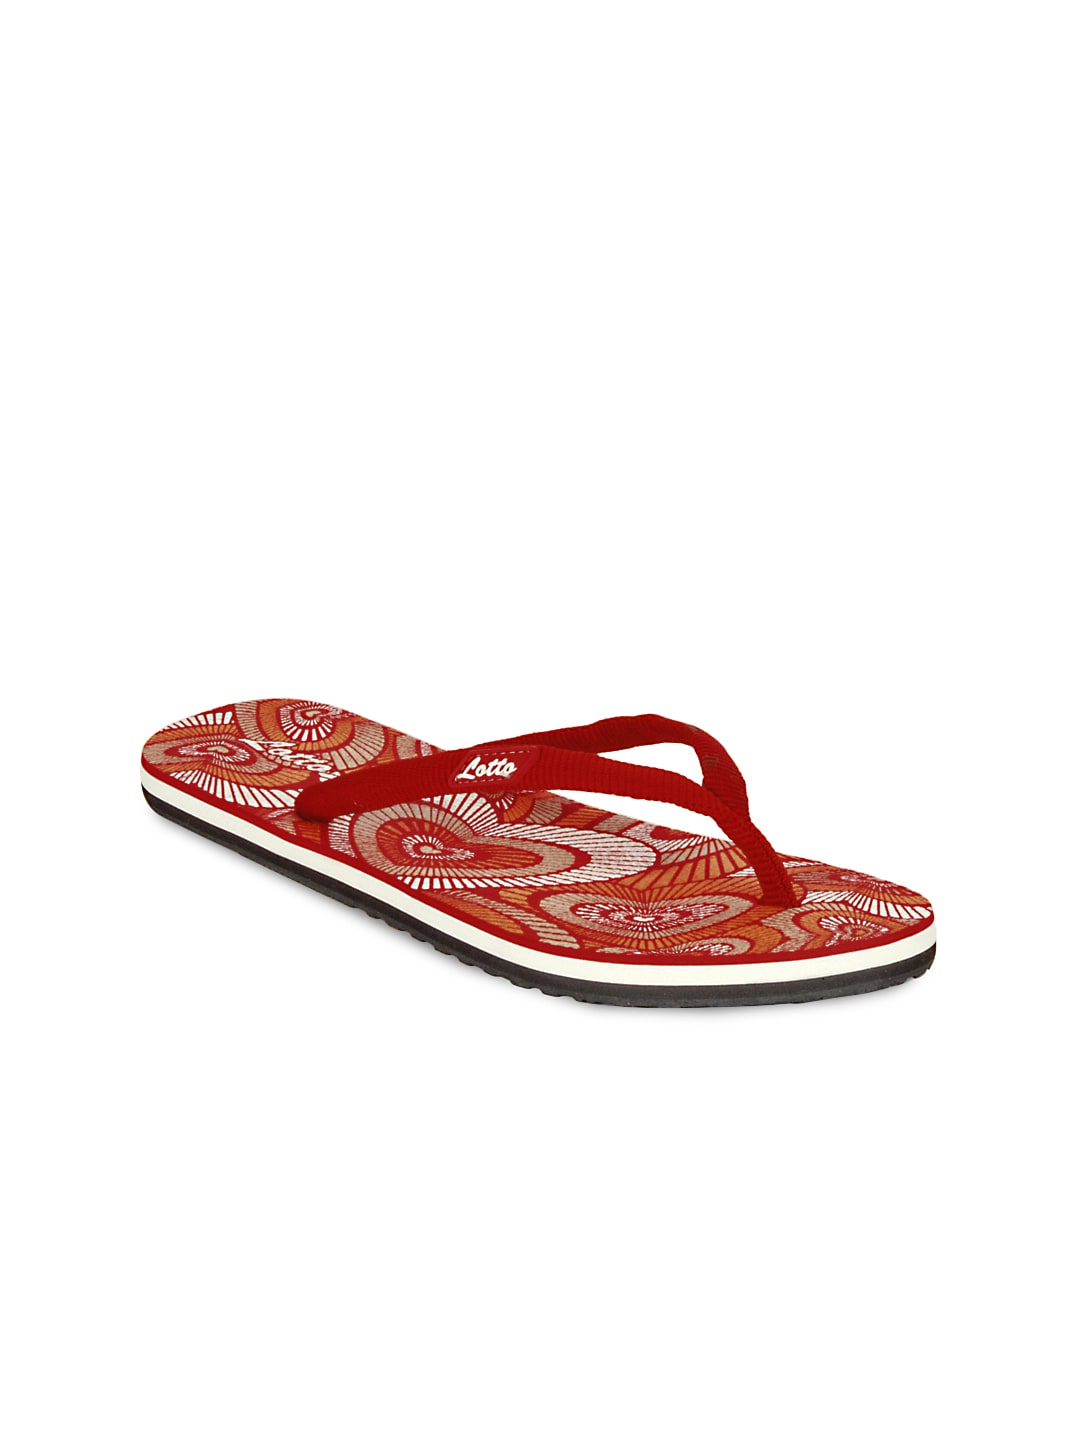

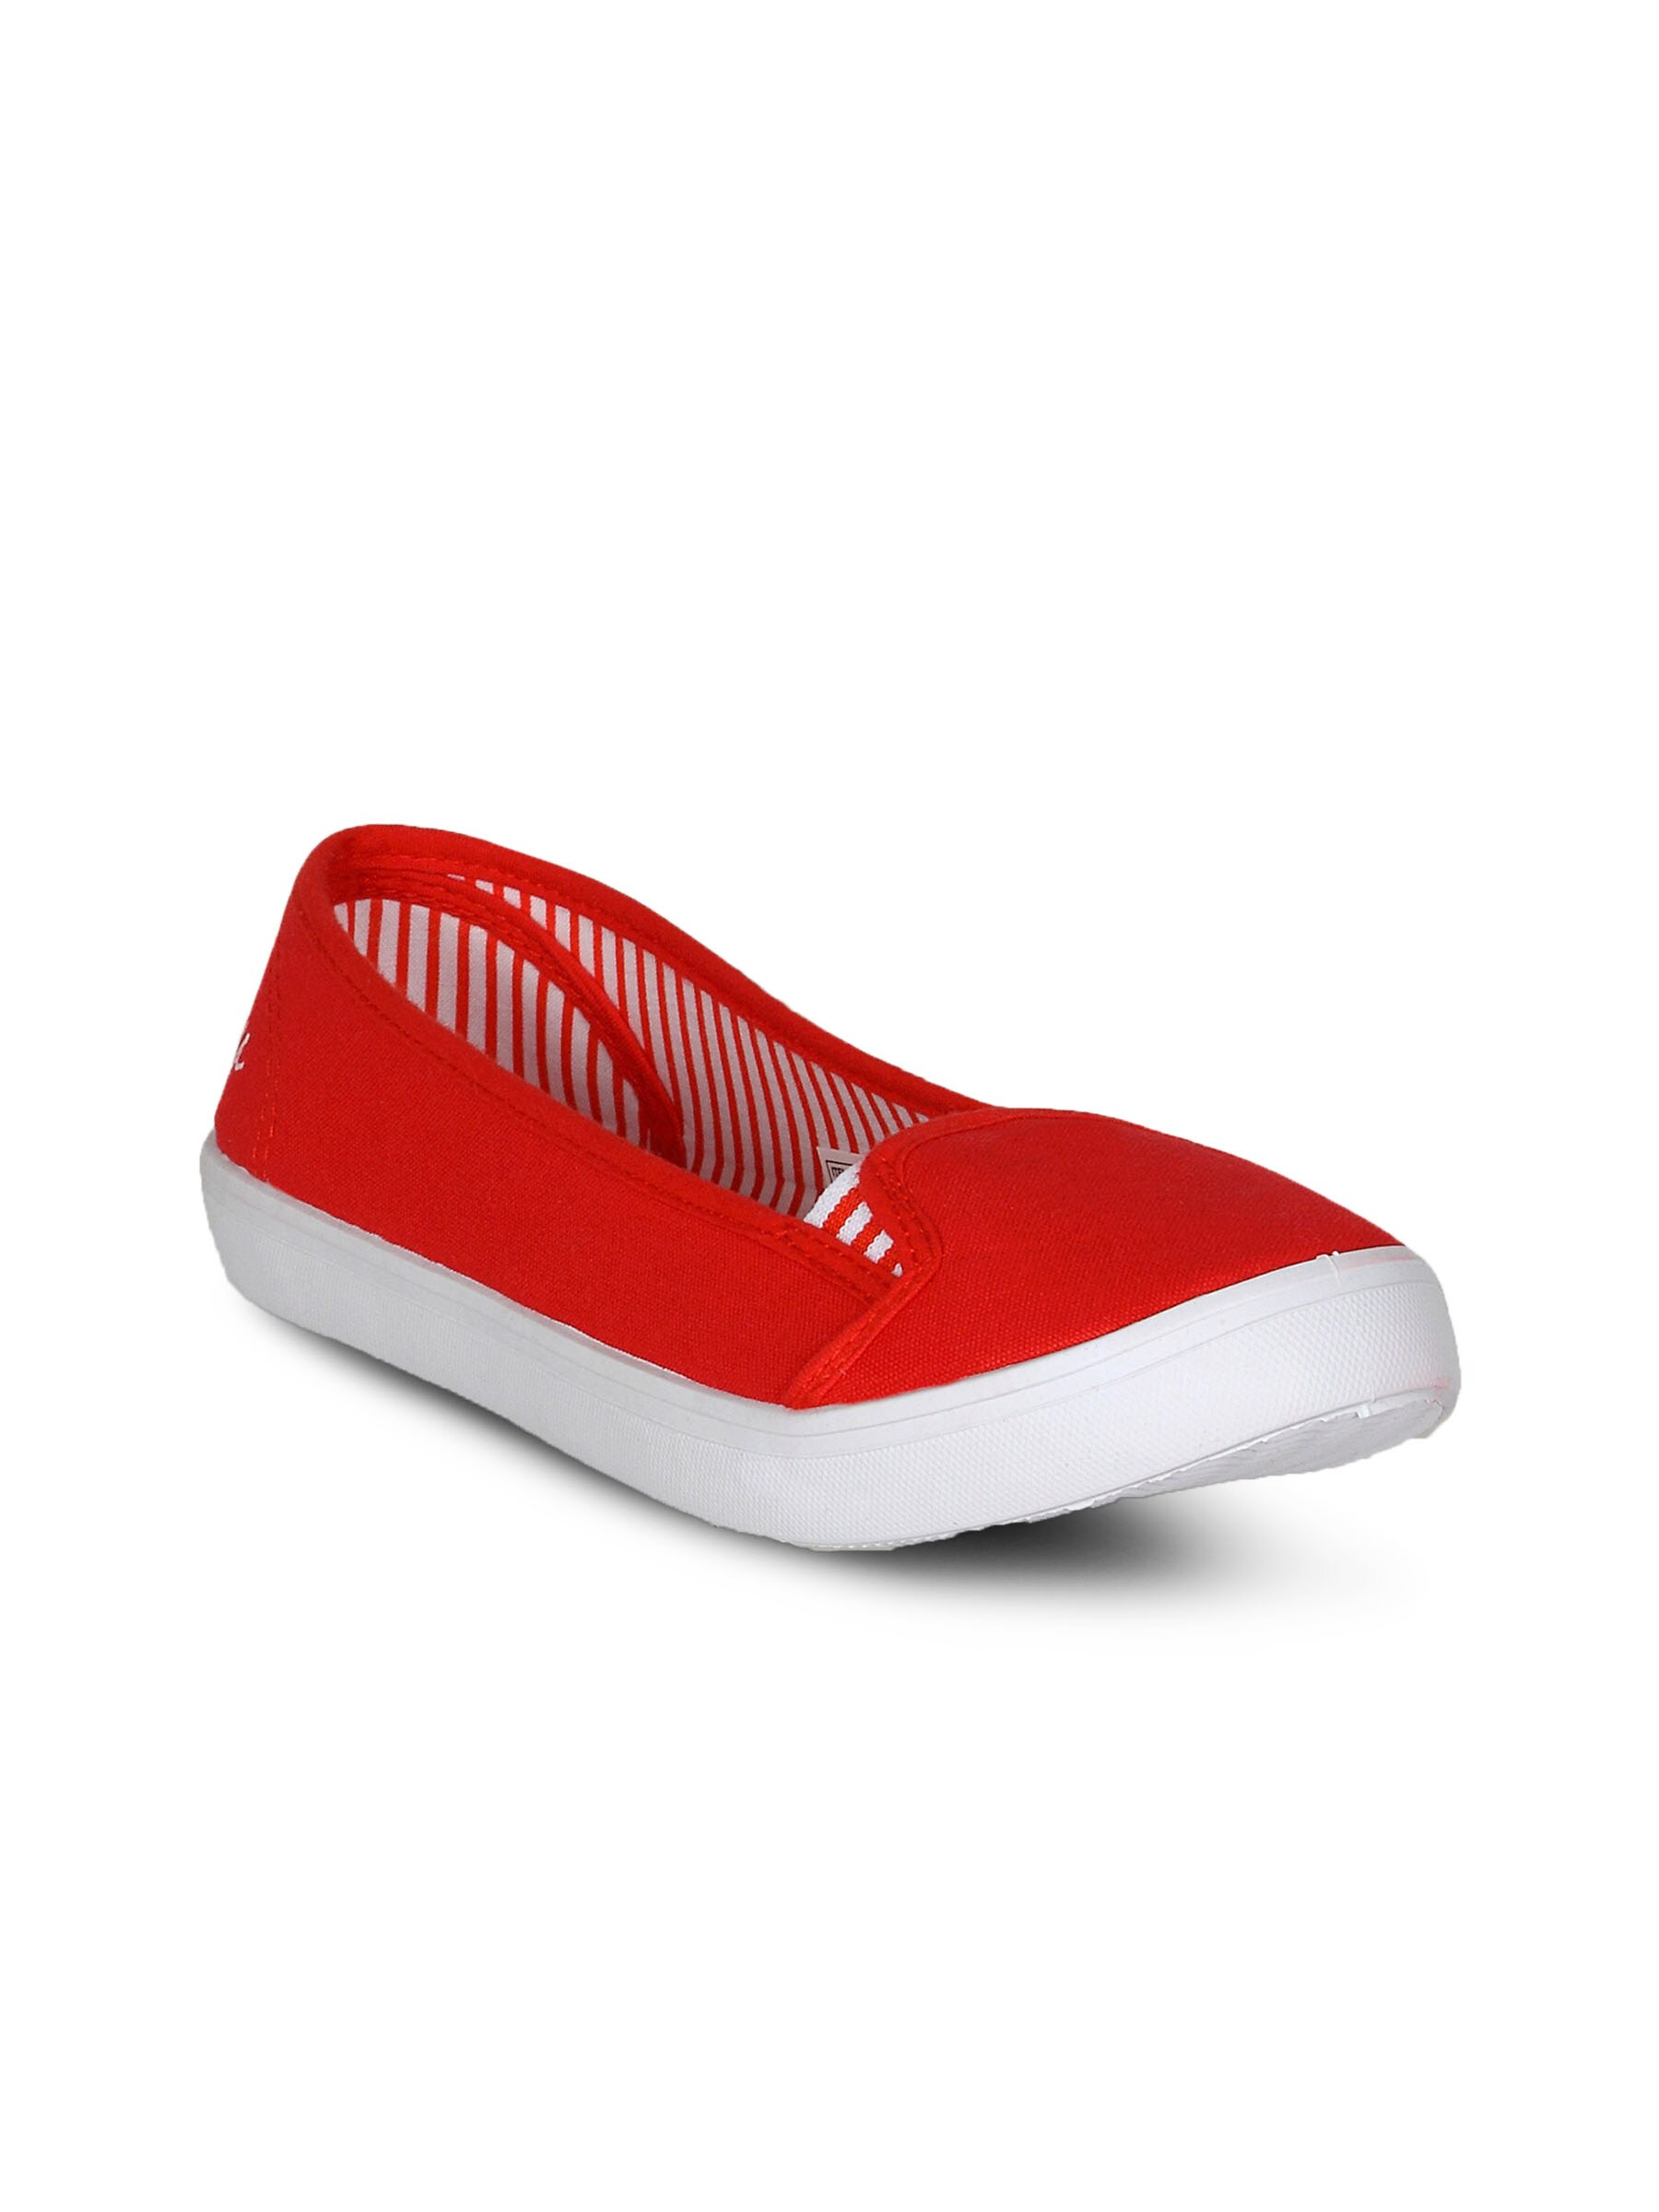

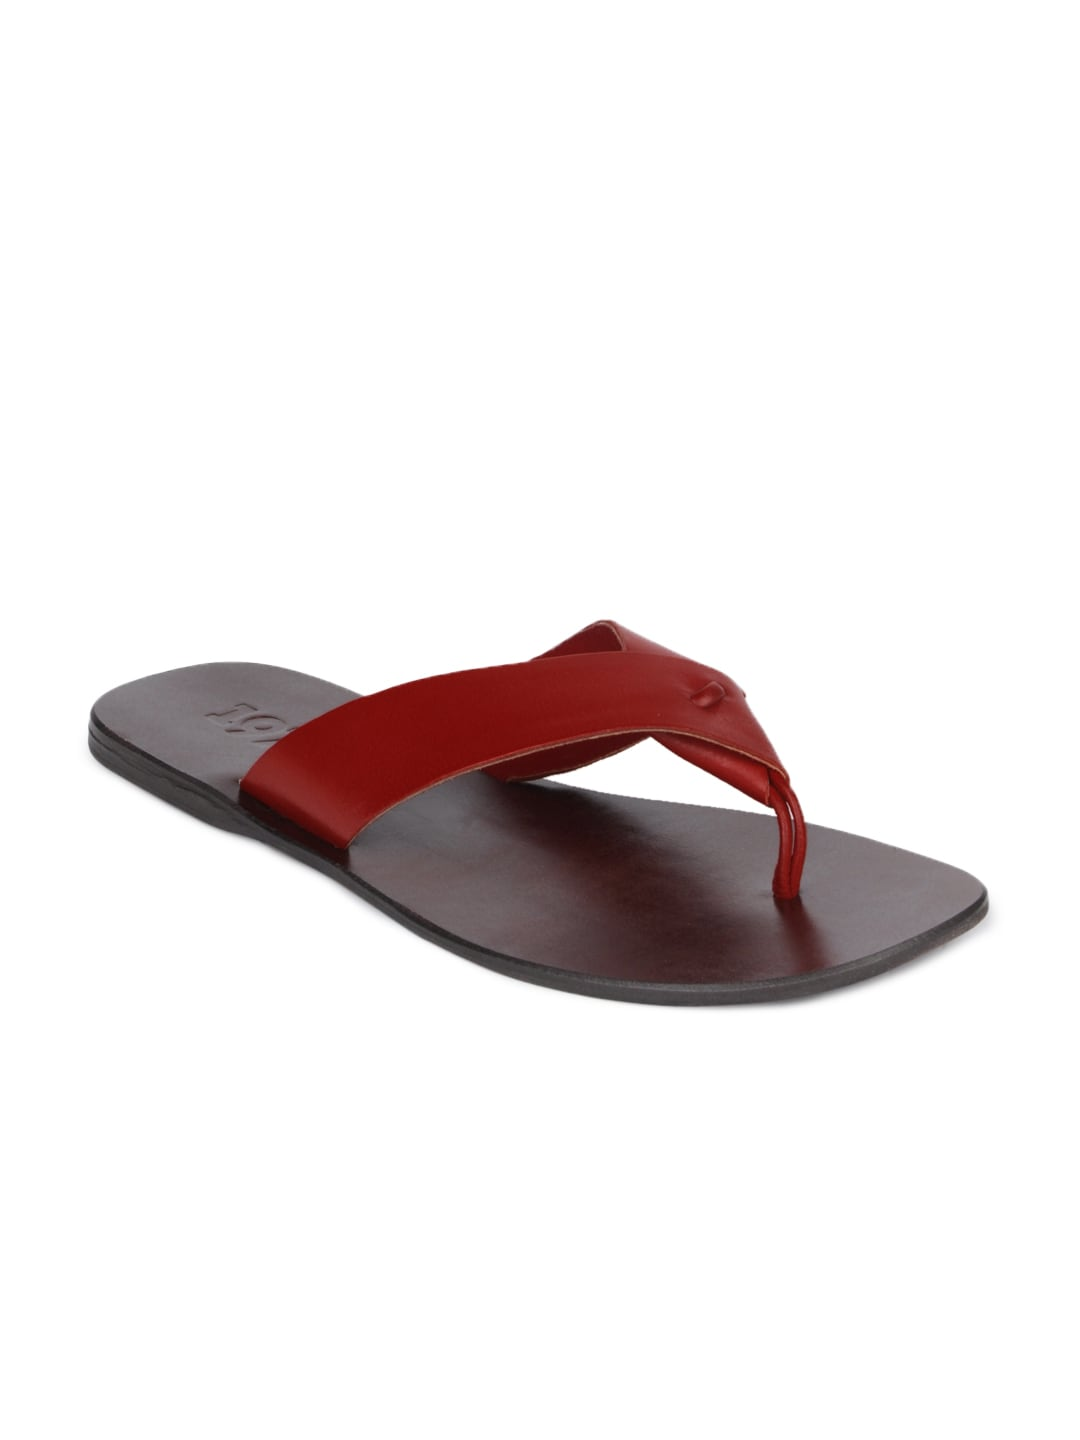

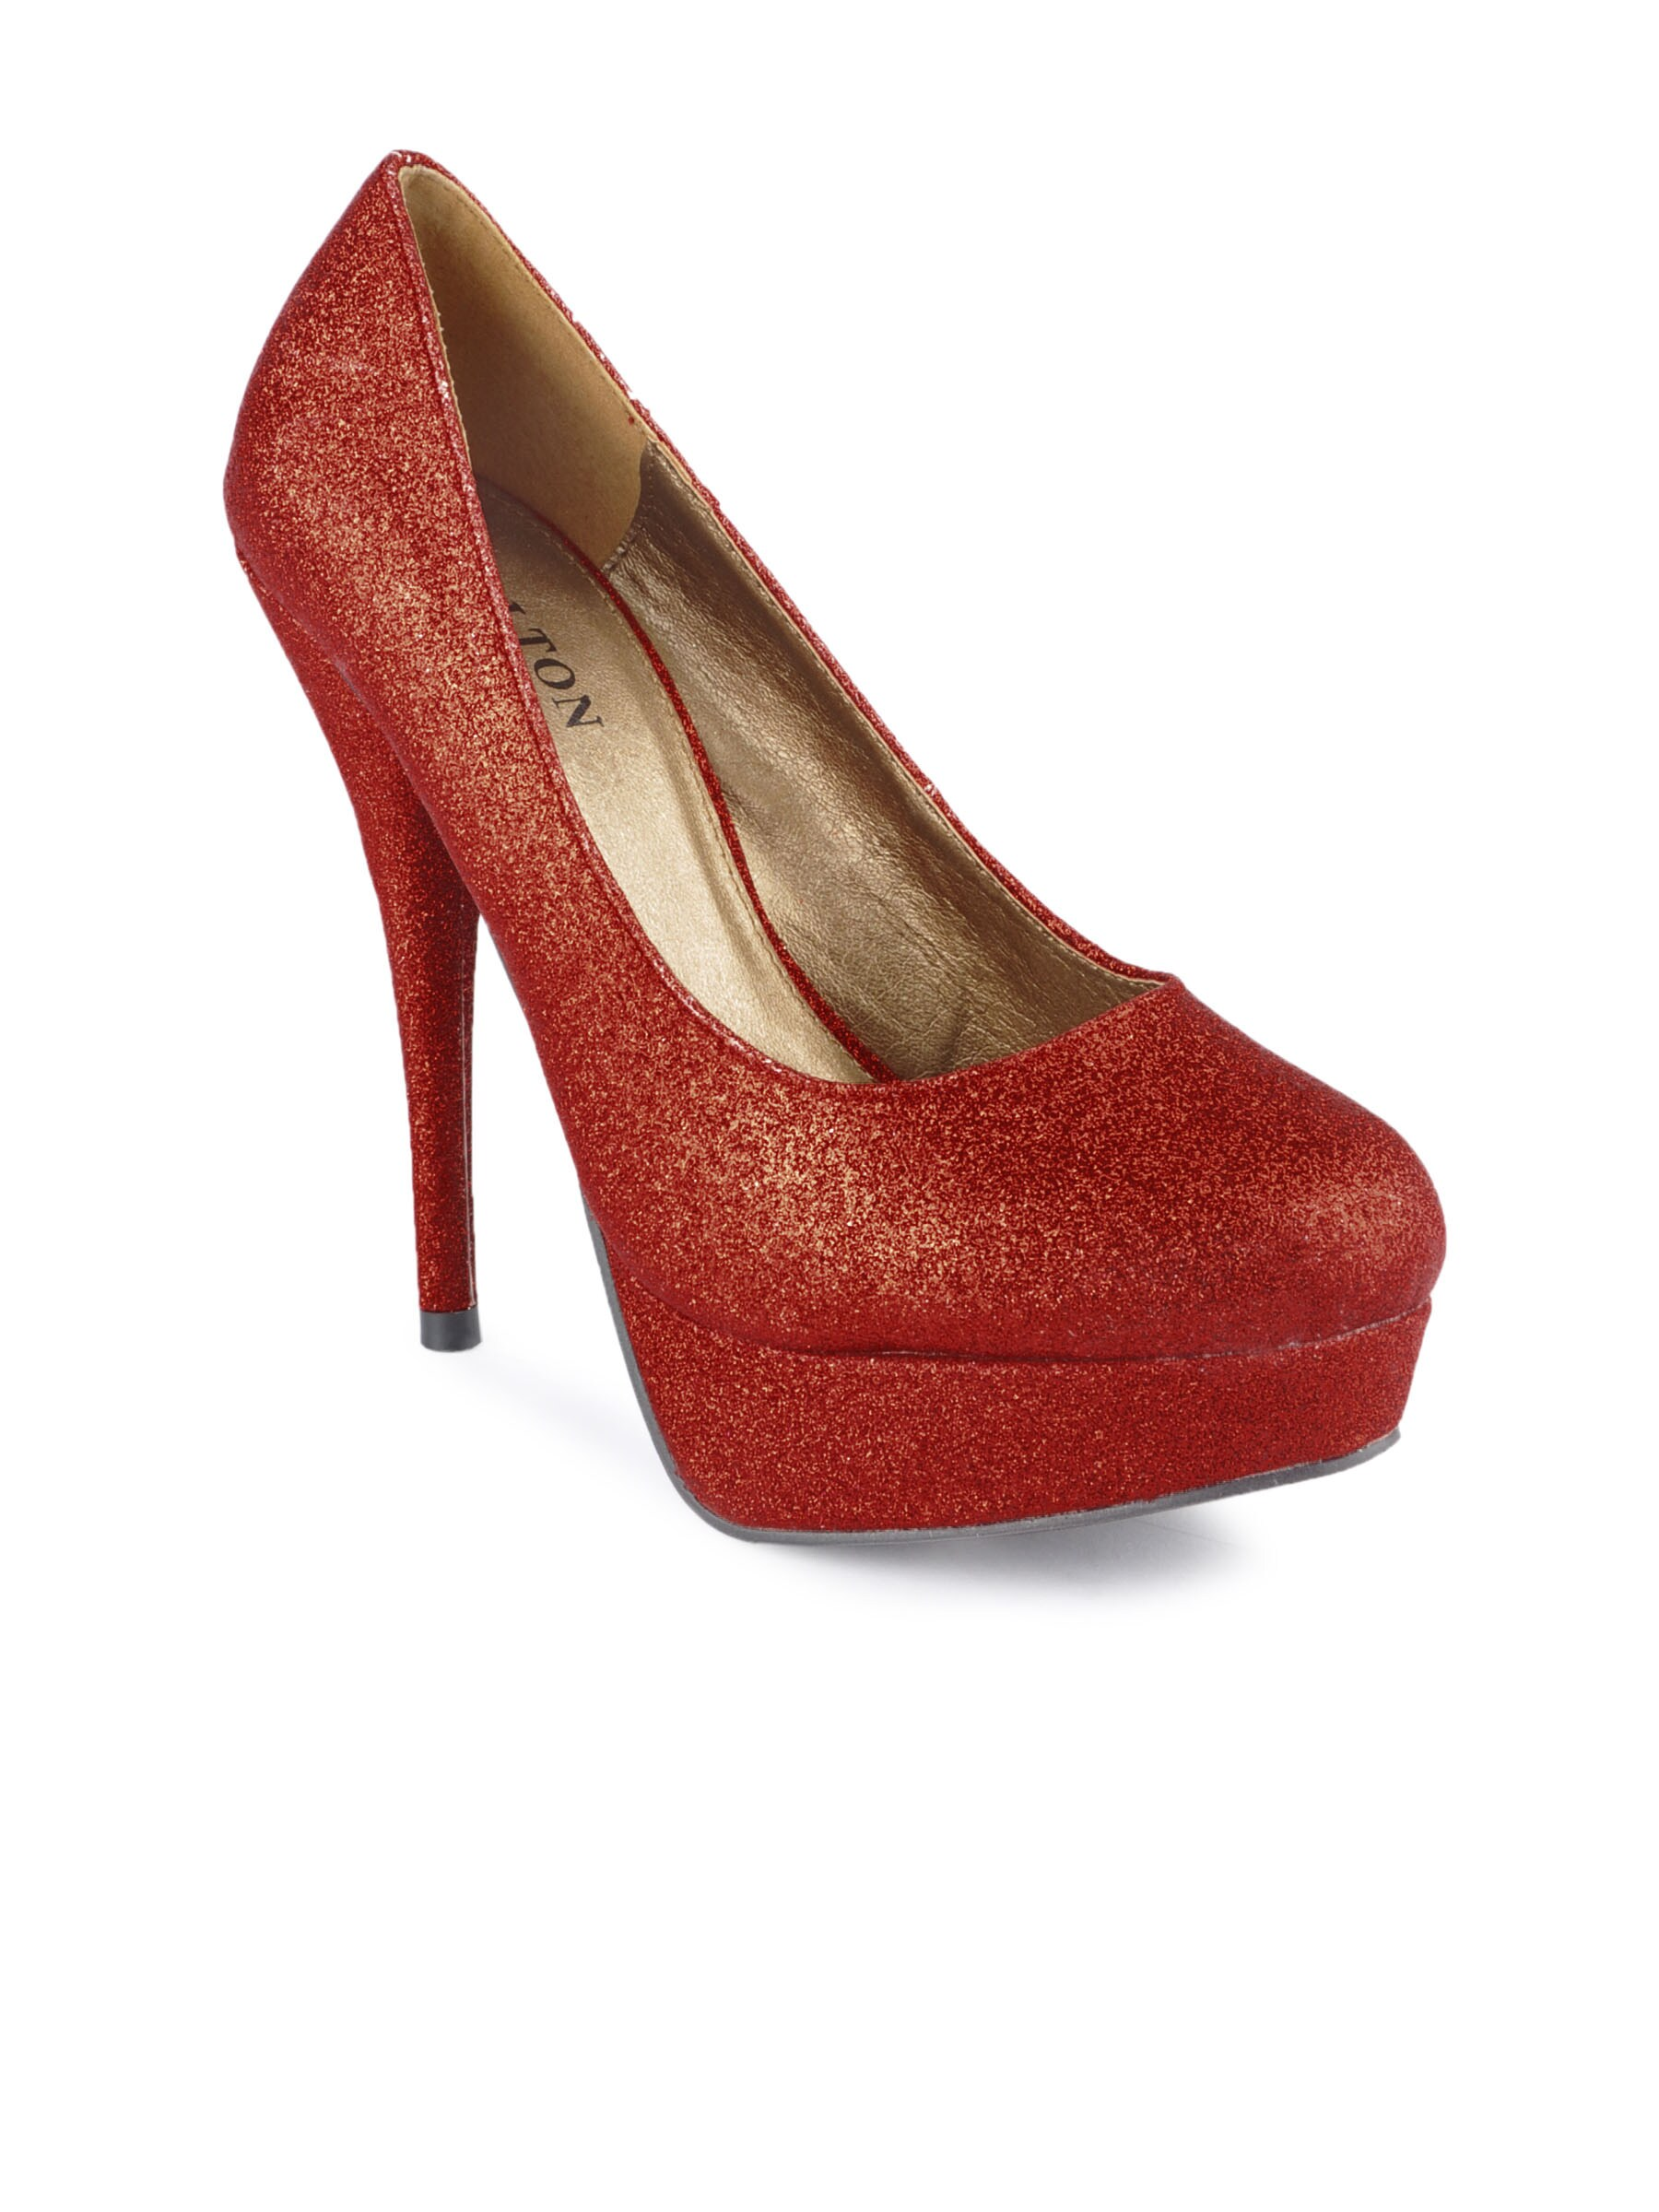

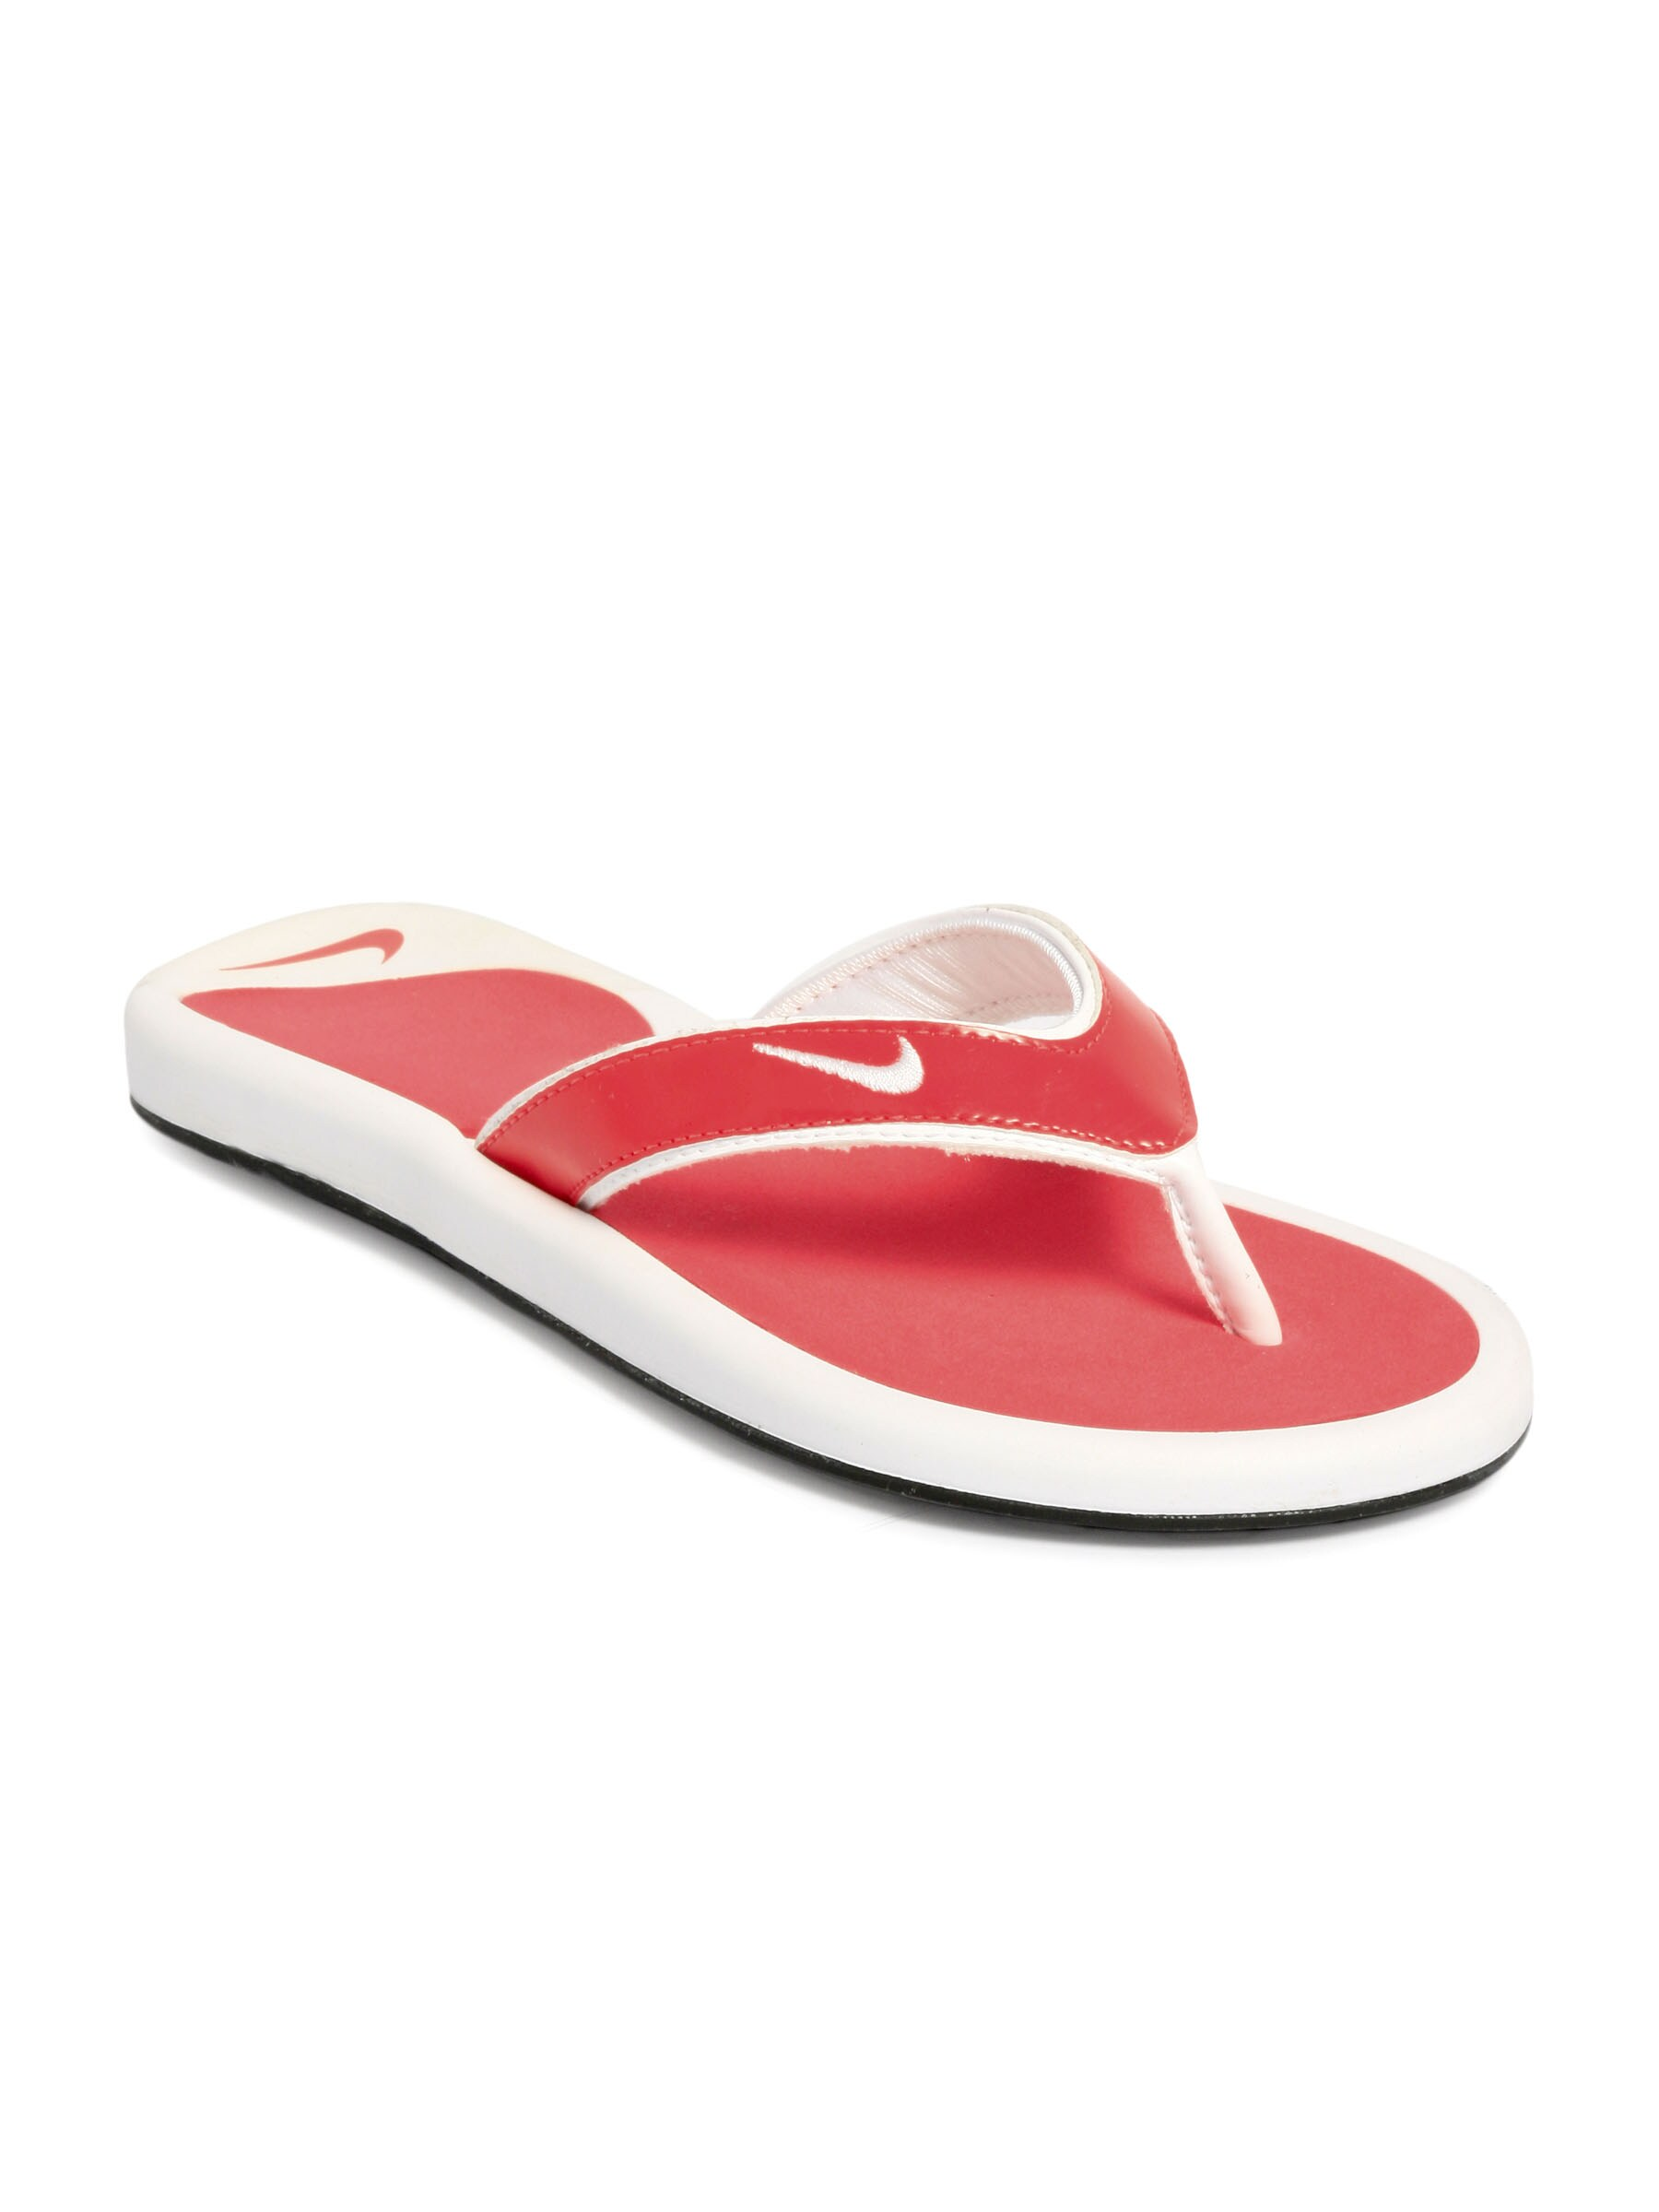

In [43]:

i = 0
for image in np.array(images)[idx][::-1]:
    i += 1
    display(DisplayImage(image, width="200px"))
    if i >= 5:
        break

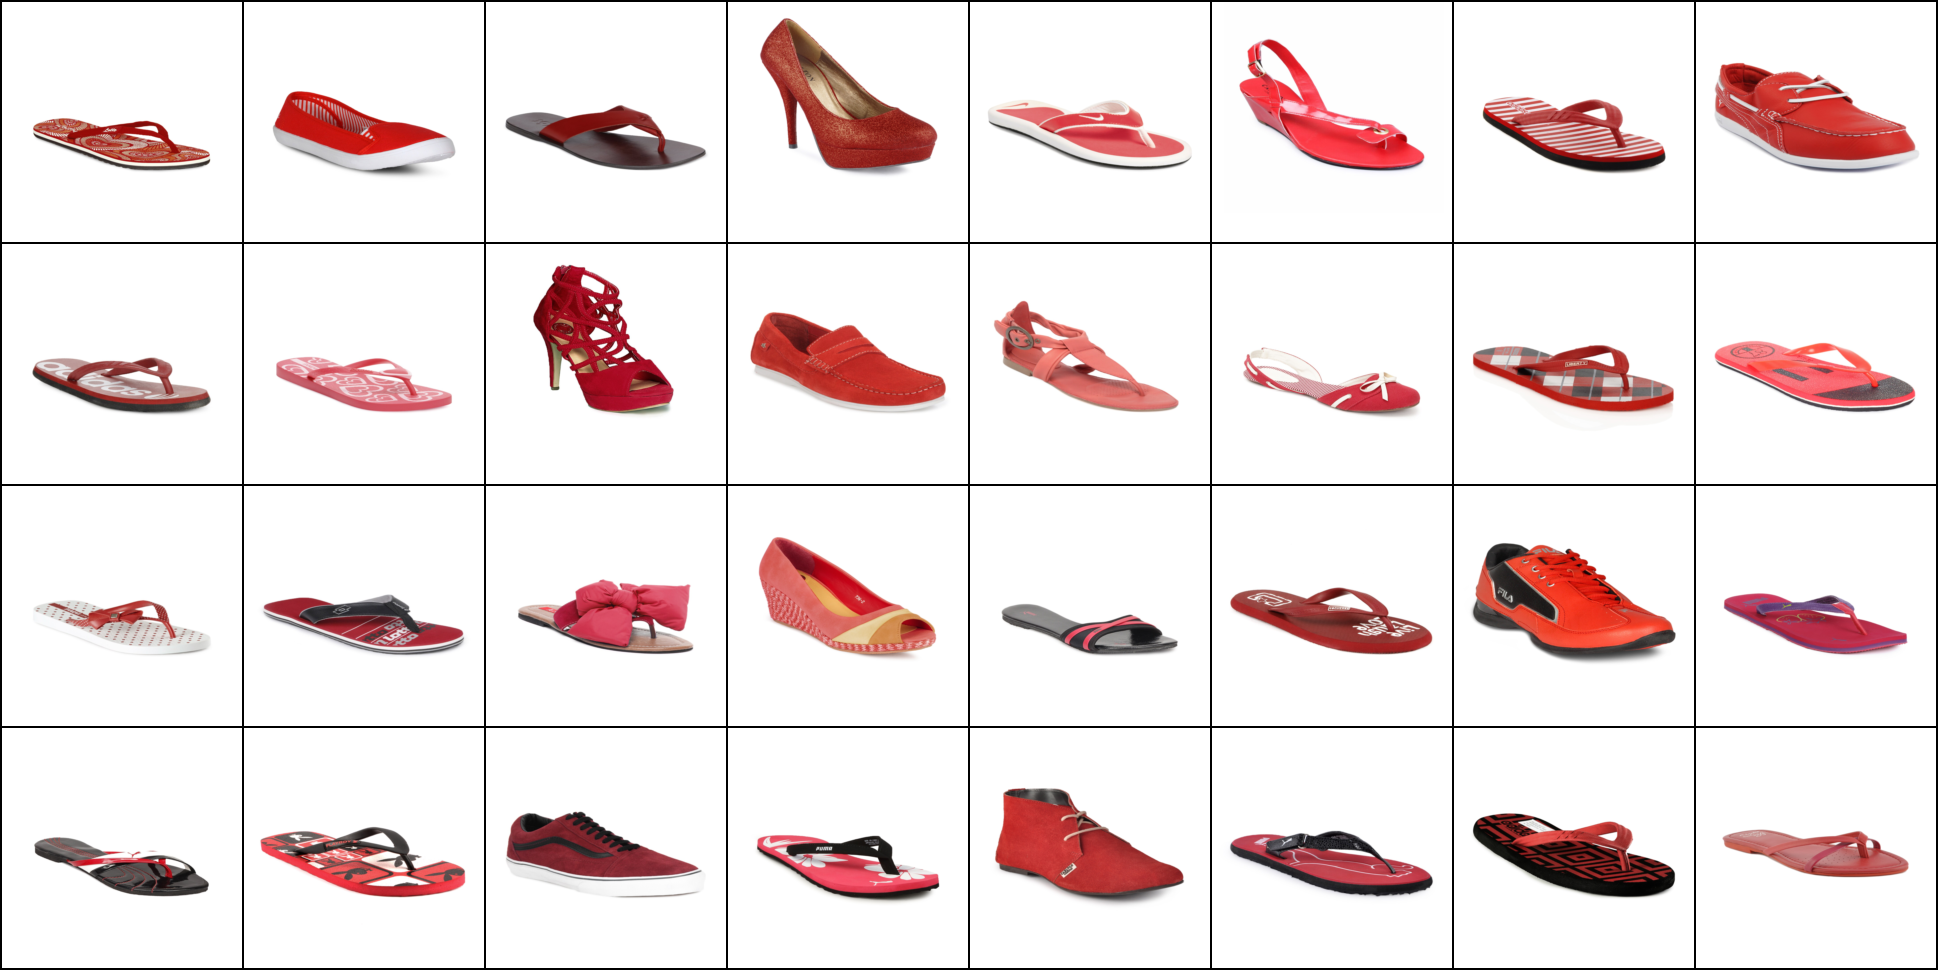

In [44]:
target_size = (240, 240)  # Replace with your desired size
num_images = 32
resize_transform = transforms.Resize(target_size)
resized_images = [resize_transform(read_image(image)) for image in np.array(images)[idx][::-1][:num_images]]
grid = make_grid(resized_images)
transforms.ToPILImage()(grid)

In [45]:
def rank_items(text_embedding, image_embeddings):
    cosine_similarity = torch.nn.CosineSimilarity()
    scores = cosine_similarity(text_embedding.unsqueeze(dim=0), image_embeddings)
    return scores.tolist()


rank_items(get_text_embedding("red"), image_embeddings)

[0.16353873908519745,
 0.1528802216053009,
 0.16428355872631073,
 0.16537651419639587,
 0.17856596410274506,
 0.21693933010101318,
 0.2176063060760498,
 0.21199095249176025,
 0.22210529446601868,
 0.15520235896110535,
 0.15785527229309082,
 0.13904885947704315,
 0.17203651368618011,
 0.19623400270938873,
 0.20926806330680847,
 0.1535467952489853,
 0.1555374413728714,
 0.14634118974208832,
 0.15580300986766815,
 0.13788282871246338,
 0.1620718538761139,
 0.1436956226825714,
 0.19575029611587524,
 0.17984436452388763,
 0.16181035339832306,
 0.16046005487442017,
 0.17343410849571228,
 0.15985193848609924,
 0.16350671648979187,
 0.17614266276359558,
 0.17788287997245789,
 0.18835949897766113,
 0.1513255536556244,
 0.16985191404819489,
 0.18001240491867065,
 0.14546026289463043,
 0.16307879984378815,
 0.23093439638614655,
 0.16145896911621094,
 0.17005638778209686,
 0.14752042293548584,
 0.14942841231822968,
 0.15493500232696533,
 0.19562193751335144,
 0.16136763989925385,
 0.17375729978084

In [46]:
def generate_product_feed(query, images, image_embeddings, num_images=32):
    scores = rank_items(get_text_embedding(query), image_embeddings)

    sort_idx = np.argsort(scores)
    ranked_images = np.array(images)[sort_idx][::-1][:num_images]

    target_size = (240, 240)
    reshape_transform = lambda image_tensor: transforms.Resize(target_size)(image_tensor).expand(3, -1, -1)
    resized_images = [reshape_transform(read_image(image)) for image in ranked_images]
    grid = make_grid(resized_images)
    display(transforms.ToPILImage()(grid))

    return ranked_images

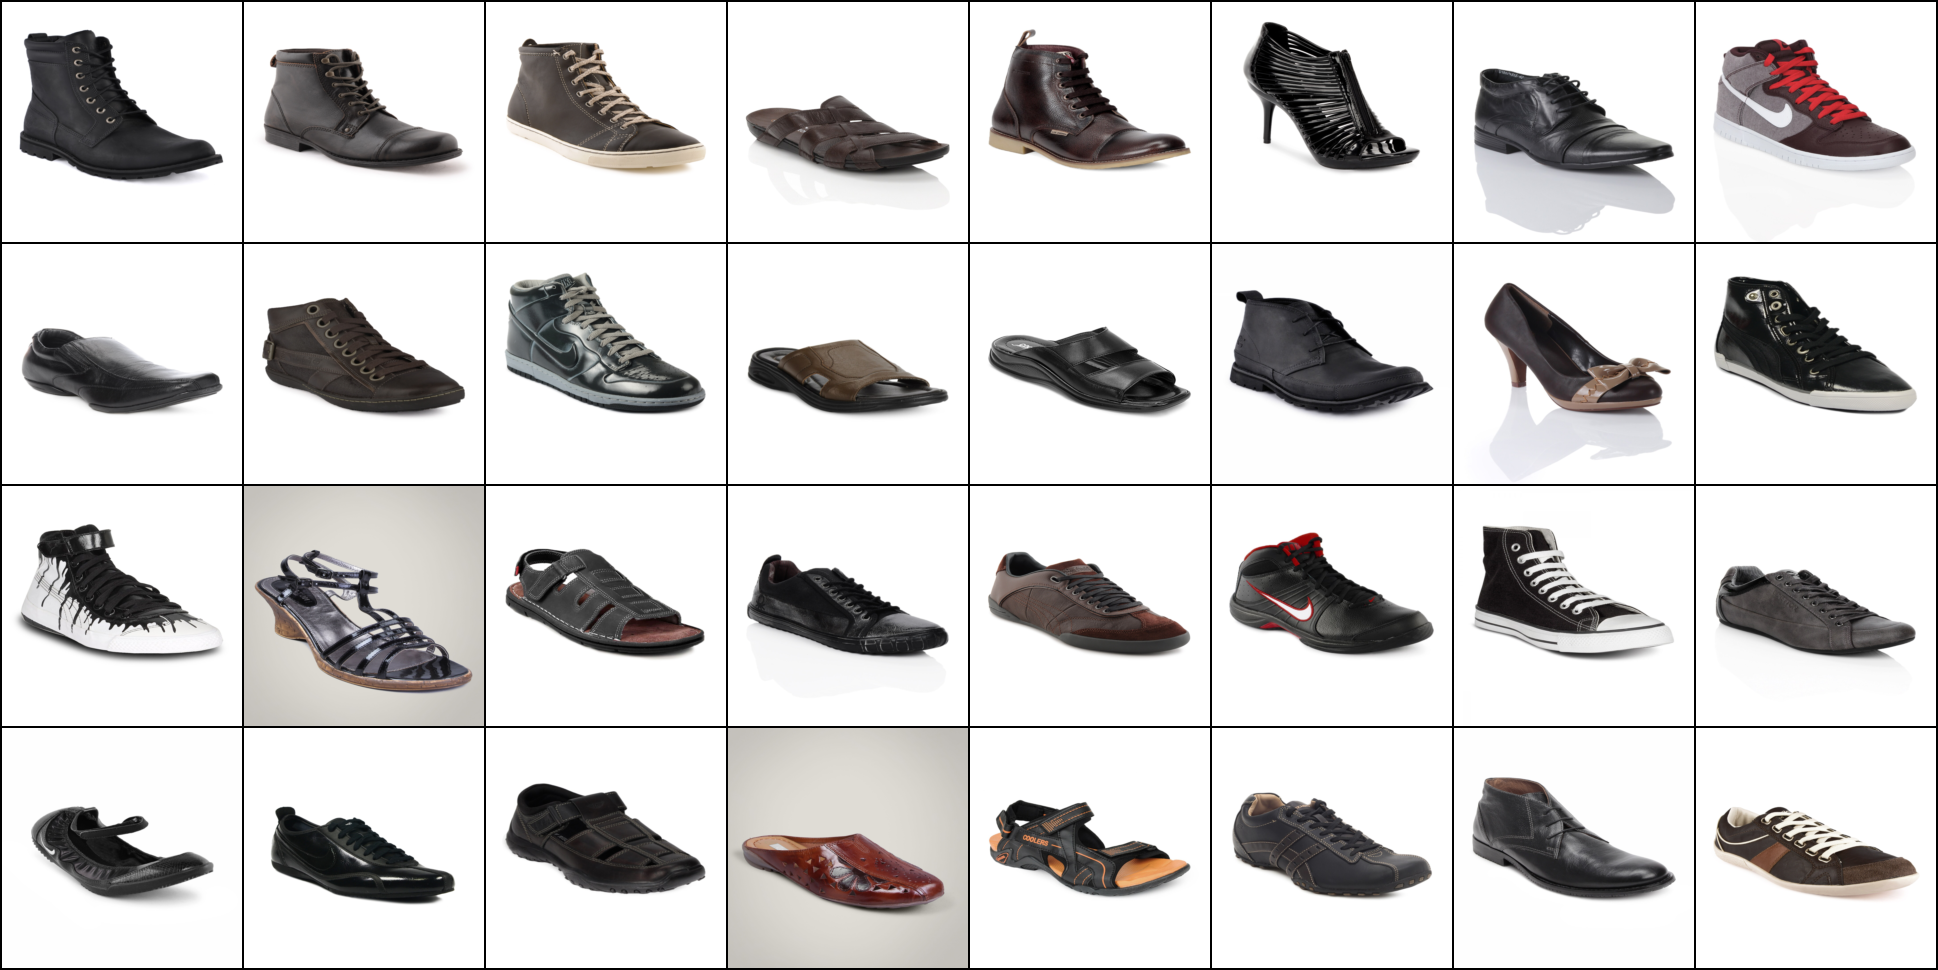

In [62]:
imgs = generate_product_feed("leather", images, image_embeddings)